# Presentación 9-06-2020

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')

In [30]:
import geopandas as gpd
import mapclassify
import geoplot

In [31]:
from glob import glob
import re
from scipy.stats import pearsonr, spearmanr
import itertools
from math import log

In [32]:
def dispersion(states):
    
    return np.std(states) / np.mean(states)

In [33]:
SHP = '/home/rdora/declaranet/data/shape/mg_sep2019_integrado/conjunto_de_datos/00ent.shp'
gdf = gpd.read_file(SHP)

In [34]:
CNTS = '/home/rdora/declaranet/data/network/edge_list.csv'
cnts = pd.read_csv(CNTS, parse_dates=['start_date'])

In [35]:
cnts = cnts[~cnts.supplier_state.str.contains('-')]

In [36]:
corrs = glob('/home/rdora/declaranet/data/corruption/encig*')

In [37]:
cols = ['state',
        'population',
        'very_high',
        'very_high_r',
        'high',
        'high_r',
        'low',
        'low_r',
        'very_low',
        'very_low_r']

digit = re.compile(r'\d+')

dfs = []
for file in corrs:
    year = int(digit.search(file).group())
    df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10, 12, 13])
    df.columns = cols
    df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                    'Distrito Federal': 'Ciudad de México',
                                    'Estado de México': 'México'})
    df['year'] = year
    dfs.append(df)
df = pd.concat(dfs)

In [38]:
cnts['same_state'] = (cnts['buyer_state'] == cnts['supplier_state']) * 1

gb_cnts = cnts.groupby('buyer_state', as_index=False).agg(
    {'single_bid': 'mean',
     'file_size': lambda x: np.quantile(x, 0.9),
     'person': 'mean',
     'contract_duration': 'mean',
     'daily_price': 'mean',
     'same_state': 'mean',
     'amount': 'mean'})

## ENCIG 2017

Encuesta Nacional de Calidad e Impacto Gubernamental

In [39]:
gb_states = cnts.groupby('buyer_state')['supplier_state'].value_counts().rename('N').reset_index()
gb_states_n = cnts.groupby('buyer_state').supplier_state.size().rename('NC').reset_index()
gb_states = gb_states[
    gb_states.buyer_state != gb_states.supplier_state].groupby(
    'buyer_state').N.apply(dispersion).rename('variation').reset_index()
gb_states = pd.merge(gb_states, gb_states_n, how='left')
gb_states['variation'] = gb_states['variation'] / gb_states['NC']
gb_states = gb_states.drop('NC', axis=1)

In [40]:
gb_cnts = pd.merge(gb_cnts, gb_states, how='left')

gb_cnts = gb_cnts.rename(columns={'buyer_state': 'state'})

gb_corr = df[df.year==2017].groupby(['state'], as_index=False).mean().drop(['high_r', 'low_r', 'year'], axis=1)

gb_cnts = pd.merge(gb_corr, gb_cnts, how='left')

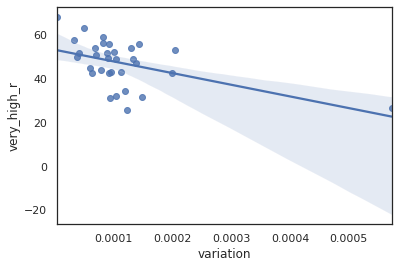

In [41]:
sns.regplot(x='variation', y='very_high_r', data=gb_cnts);

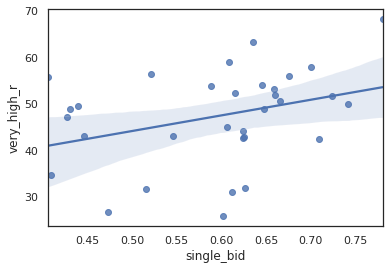

In [42]:
sns.regplot(x='single_bid', y='very_high_r', data=gb_cnts);

In [43]:
gb_cnts.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation
very_high_r,1.000000,-0.552870,0.337489,0.210295,-0.165353,-0.012832,0.120807,0.104858,0.337855,-0.470028
very_low_r,-0.552870,1.000000,-0.204054,0.026870,0.020811,-0.054513,0.053592,-0.337757,-0.193557,0.500190
single_bid,0.337489,-0.204054,1.000000,0.289654,-0.303886,-0.282991,-0.307918,-0.219941,-0.332845,-0.511364
file_size,0.210295,0.026870,0.289654,1.000000,-0.295167,-0.383019,-0.160633,-0.273664,-0.388901,-0.229738
person,-0.165353,0.020811,-0.303886,-0.295167,1.000000,0.198680,-0.026393,0.159091,-0.015762,0.530792
contract_duration,-0.012832,-0.054513,-0.282991,-0.383019,0.198680,1.000000,0.170455,0.072947,0.387463,0.096408
daily_price,0.120807,0.053592,-0.307918,-0.160633,-0.026393,0.170455,1.000000,-0.149560,0.659457,0.146261
same_state,0.104858,-0.337757,-0.219941,-0.273664,0.159091,0.072947,-0.149560,1.000000,0.114370,-0.233504
amount,0.337855,-0.193557,-0.332845,-0.388901,-0.015762,0.387463,0.659457,0.114370,1.000000,0.042889
variation,-0.470028,0.500190,-0.511364,-0.229738,0.530792,0.096408,0.146261,-0.233504,0.042889,1.000000


## ENCRIGE 2016

Encuesta Nacional de Calidad Regulatoria e Impacto Gubernamental en Empresas

In [44]:
df = pd.read_csv('/home/rdora/declaranet/data/corruption/encrige_2016.csv')

cols = ['state',
        'sample',
        'c_very_high',
        'c_very_high_r',
        'c_high',
        'c_high_r',
        'c_low',
        'c_low_r']

df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10])
df.columns = cols
df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                'Distrito Federal': 'Ciudad de México',
                                'Estado de México': 'México'})

gb_cnts = pd.merge(gb_cnts, df[['state', 'c_very_high_r', 'c_low_r']], how='left')

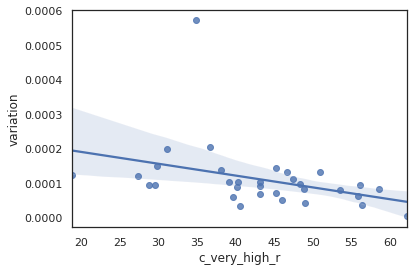

In [45]:
sns.regplot(x='c_very_high_r', y='variation', data=gb_cnts);

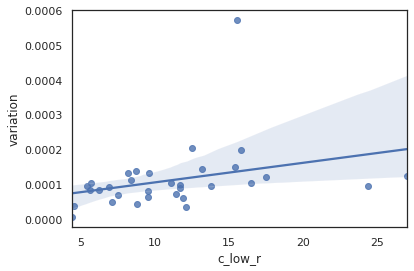

In [46]:
sns.regplot(x='c_low_r', y='variation', data=gb_cnts);

In [47]:
gb_cnts.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,variation,c_very_high_r,c_low_r
very_high_r,1.000000,-0.552870,0.337489,0.210295,-0.165353,-0.012832,0.120807,0.104858,0.337855,-0.470028,0.583150,-0.684727
very_low_r,-0.552870,1.000000,-0.204054,0.026870,0.020811,-0.054513,0.053592,-0.337757,-0.193557,0.500190,-0.379908,0.567974
single_bid,0.337489,-0.204054,1.000000,0.289654,-0.303886,-0.282991,-0.307918,-0.219941,-0.332845,-0.511364,0.344638,-0.188451
file_size,0.210295,0.026870,0.289654,1.000000,-0.295167,-0.383019,-0.160633,-0.273664,-0.388901,-0.229738,0.400001,-0.141912
person,-0.165353,0.020811,-0.303886,-0.295167,1.000000,0.198680,-0.026393,0.159091,-0.015762,0.530792,-0.202933,0.022181
contract_duration,-0.012832,-0.054513,-0.282991,-0.383019,0.198680,1.000000,0.170455,0.072947,0.387463,0.096408,-0.058845,-0.099542
daily_price,0.120807,0.053592,-0.307918,-0.160633,-0.026393,0.170455,1.000000,-0.149560,0.659457,0.146261,0.003483,-0.128689
same_state,0.104858,-0.337757,-0.219941,-0.273664,0.159091,0.072947,-0.149560,1.000000,0.114370,-0.233504,0.035564,-0.307424
amount,0.337855,-0.193557,-0.332845,-0.388901,-0.015762,0.387463,0.659457,0.114370,1.000000,0.042889,0.134189,-0.323740
variation,-0.470028,0.500190,-0.511364,-0.229738,0.530792,0.096408,0.146261,-0.233504,0.042889,1.000000,-0.534372,0.510724


# Coefficient of Variation across buyers and suppliers

Within state and across state variation.

In [48]:
def company_variation(contracts):
    
    return np.std(contracts) / (np.mean(contracts) * sum(contracts))

In [49]:
gb_buyer_within = cnts.groupby(['buyer', 'buyer_state', 'supplier', 'supplier_state'], as_index=False)['person'].count()
gb_buyer_within = gb_buyer_within[gb_buyer_within.buyer_state == gb_buyer_within.supplier_state].drop(['buyer_state', 'supplier_state'], axis=1)
gb_buyer_within = gb_buyer_within.groupby('buyer').agg(buyer_variation_within = ('person', company_variation)).reset_index()

gb_supplier_within = cnts.groupby(['buyer', 'buyer_state', 'supplier', 'supplier_state'], as_index=False)['person'].count()
gb_supplier_within = gb_supplier_within[gb_supplier_within.buyer_state == gb_supplier_within.supplier_state].drop(['buyer_state', 'supplier_state'], axis=1)
gb_supplier_within = gb_supplier_within.groupby('supplier').agg(supplier_variation_within = ('person', company_variation)).reset_index()

In [50]:
gb_buyer_across = cnts.groupby(['buyer', 'buyer_state', 'supplier', 'supplier_state'], as_index=False)['person'].count()
gb_buyer_across = gb_buyer_across[gb_buyer_across.buyer_state != gb_buyer_across.supplier_state].drop(['buyer_state', 'supplier_state'], axis=1)
gb_buyer_across = gb_buyer_across.groupby('buyer').agg(buyer_variation_across = ('person', company_variation)).reset_index()

gb_supplier_across = cnts.groupby(['buyer', 'buyer_state', 'supplier', 'supplier_state'], as_index=False)['person'].count()
gb_supplier_across = gb_supplier_across[gb_supplier_across.buyer_state != gb_supplier_across.supplier_state].drop(['buyer_state', 'supplier_state'], axis=1)
gb_supplier_across = gb_supplier_across.groupby('supplier').agg(supplier_variation_across = ('person', company_variation)).reset_index()

In [51]:
gb_buyer = cnts.groupby(['buyer', 'supplier'], as_index=False)['person'].count()

gb_buyer = gb_buyer.groupby('buyer').agg(buyer_variation = ('person', company_variation)).reset_index()

gb_supplier = cnts.groupby(['supplier', 'buyer'], as_index=False)['person'].count()

gb_supplier = gb_supplier.groupby('supplier').agg(supplier_variation = ('person', company_variation)).reset_index()

In [52]:
cnts = pd.merge(cnts, gb_buyer, how='left')
cnts = pd.merge(cnts, gb_buyer_within, how='left')
cnts = pd.merge(cnts, gb_buyer_across, how='left')

cnts = pd.merge(cnts, gb_supplier, how='left')
cnts = pd.merge(cnts, gb_supplier_within, how='left')
cnts = pd.merge(cnts, gb_supplier_across, how='left')

In [62]:
gb_cnts = cnts.groupby('buyer_state', as_index=False).agg(
    {'single_bid': 'mean',
     'file_size': lambda x: np.quantile(x, 0.9),
     'person': 'mean',
     'contract_duration': 'mean',
     'daily_price': 'mean',
     'same_state': 'mean',
     'amount': 'mean',
     'supplier_variation': 'median',
     'buyer_variation': 'median',
     'supplier_variation_within': 'median',
     'buyer_variation_within': 'median',
     'supplier_variation_across': 'median',
     'buyer_variation_across': 'median'})

In [63]:
cols = ['state',
        'population',
        'very_high',
        'very_high_r',
        'high',
        'high_r',
        'low',
        'low_r',
        'very_low',
        'very_low_r']

digit = re.compile(r'\d+')

dfs = []
for file in corrs:
    year = int(digit.search(file).group())
    df = pd.read_csv(file, usecols=[0, 1, 3, 4, 6, 7, 9, 10, 12, 13])
    df.columns = cols
    df['state'] = df.state.replace({'Querétaro de Arteaga': 'Querétaro',
                                    'Distrito Federal': 'Ciudad de México',
                                    'Estado de México': 'México'})
    df['year'] = year
    dfs.append(df)
df = pd.concat(dfs)

In [64]:
gb_cnts = gb_cnts.rename(columns={'buyer_state': 'state'})

gb_corr = df[df.year==2017].groupby(['state'], as_index=False).mean().drop(['high_r', 'low_r', 'year'], axis=1)

gb_cnts = pd.merge(gb_corr, gb_cnts, how='left')

In [65]:
gb_cnts.corr(method='spearman')

,very_high_r,very_low_r,single_bid,file_size,person,contract_duration,daily_price,same_state,amount,supplier_variation,buyer_variation,supplier_variation_within,buyer_variation_within,supplier_variation_across,buyer_variation_across
very_high_r,1.000000,-0.552870,0.337489,0.210295,-0.165353,-0.012832,0.120807,0.104858,0.337855,-0.339872,-0.280477,-0.276469,-0.321907,-0.109828,-0.105591
very_low_r,-0.552870,1.000000,-0.204054,0.026870,0.020811,-0.054513,0.053592,-0.337757,-0.193557,0.151751,0.243649,0.219728,0.241992,0.117426,-0.212710
single_bid,0.337489,-0.204054,1.000000,0.289654,-0.303886,-0.282991,-0.307918,-0.219941,-0.332845,-0.668988,-0.595308,-0.719641,-0.390396,-0.034464,-0.556452
file_size,0.210295,0.026870,0.289654,1.000000,-0.295167,-0.383019,-0.160633,-0.273664,-0.388901,-0.723583,-0.538874,-0.273046,-0.379527,-0.606620,-0.506526
person,-0.165353,0.020811,-0.303886,-0.295167,1.000000,0.198680,-0.026393,0.159091,-0.015762,0.427053,0.174487,0.288516,0.255865,-0.122823,0.181818
contract_duration,-0.012832,-0.054513,-0.282991,-0.383019,0.198680,1.000000,0.170455,0.072947,0.387463,0.387830,0.160191,0.155073,0.073314,0.008433,0.258798
daily_price,0.120807,0.053592,-0.307918,-0.160633,-0.026393,0.170455,1.000000,-0.149560,0.659457,0.188783,0.016862,0.085235,0.323314,0.210999,0.026760
same_state,0.104858,-0.337757,-0.219941,-0.273664,0.159091,0.072947,-0.149560,1.000000,0.114370,0.317082,0.283724,0.341307,-0.289223,-0.080477,0.716276
amount,0.337855,-0.193557,-0.332845,-0.388901,-0.015762,0.387463,0.659457,0.114370,1.000000,0.278959,0.086877,0.067088,0.162390,0.117874,0.250733
supplier_variation,-0.339872,0.151751,-0.668988,-0.723583,0.427053,0.387830,0.188783,0.317082,0.278959,1.000000,0.615469,0.695995,0.585777,0.389368,0.593842


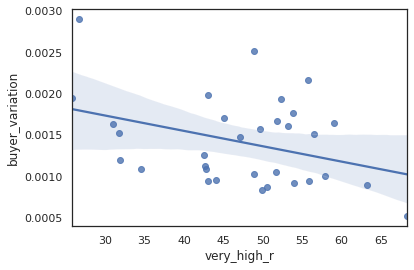

In [66]:
sns.regplot(x='very_high_r', y='buyer_variation', data=gb_cnts);

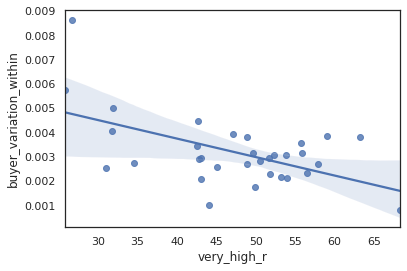

In [60]:
sns.regplot(x='very_high_r', y='buyer_variation_within', data=gb_cnts);

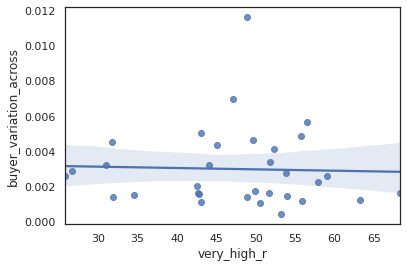

In [59]:
sns.regplot(x='very_high_r', y='buyer_variation_across', data=gb_cnts);

# Mapas

In [67]:
gdf.columns = gdf.columns.str.lower()

In [70]:
# Number of contracts
# By buyer
gb_buyer = cnts.groupby('buyer_state').person.count().reset_index().rename(columns={
    'buyer_state': 'nomgeo', 'person': 'buyer_contracts'})
gdf = pd.merge(gdf, gb_buyer, on='nomgeo')

# Number of contracts
# By Supplier
gb_seller = cnts.groupby('supplier_state').person.count().reset_index().rename(columns={
    'supplier_state': 'nomgeo', 'person': 'supplier_contracts'})
gdf = pd.merge(gdf, gb_seller, on='nomgeo')

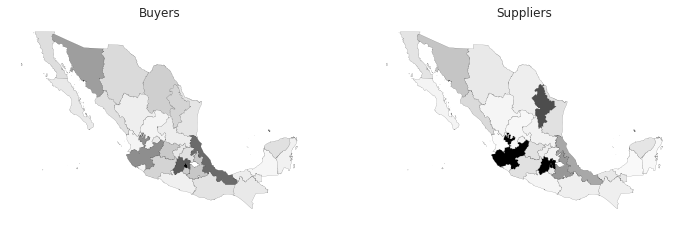

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# fig.suptitle('Number of contracts per state', fontsize=16)
gdf.plot('supplier_contracts',
         vmax=100000,
         cmap='Greys',
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         ax=ax[1])
ax[1].set_axis_off()
ax[1].set_title("Suppliers")
gdf.plot('buyer_contracts',
         vmax=100000,
         cmap='Greys',
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         ax=ax[0])
ax[0].set_axis_off()
ax[0].set_title("Buyers");

In [73]:
# Buyer / Supplier ratio
gb_buyer = pd.merge(gb_buyer, gb_seller, how='left')

gb_buyer['ratio'] = gb_buyer['buyer_contracts'] / gb_buyer['supplier_contracts']

gdf = pd.merge(gdf, gb_buyer[['nomgeo', 'ratio']], how='left')

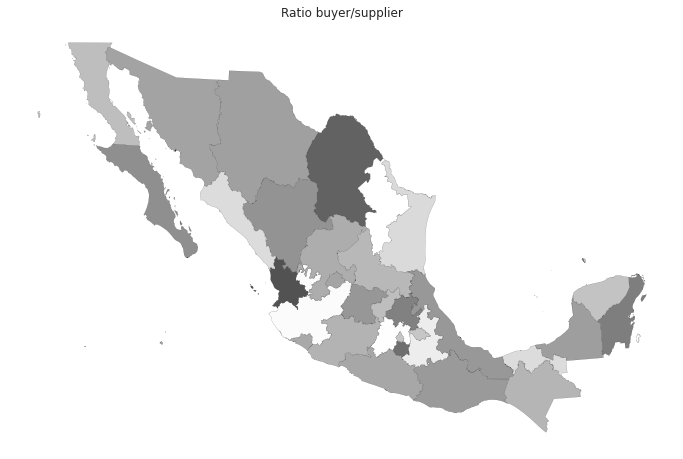

In [75]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot('ratio',
         vmax=2.5,
         cmap='Greys',
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         k=10,
         ax=ax)
ax.set_title("Ratio buyer/supplier")
ax.set_axis_off()

In [77]:
# Supplier in their own state
gb_same = cnts.loc[
    cnts.supplier_state == cnts.buyer_state].groupby('buyer_state').person.count().rename('same_state').reset_index()
gb_same.columns = ['nomgeo', 'same_state']
gb_same = pd.merge(gb_same, gb_buyer, how='left')

gb_same['same_state_ratio'] = gb_same['same_state'] / gb_same['buyer_contracts']

gdf = pd.merge(gdf, gb_same[['nomgeo', 'same_state_ratio']], how='left')

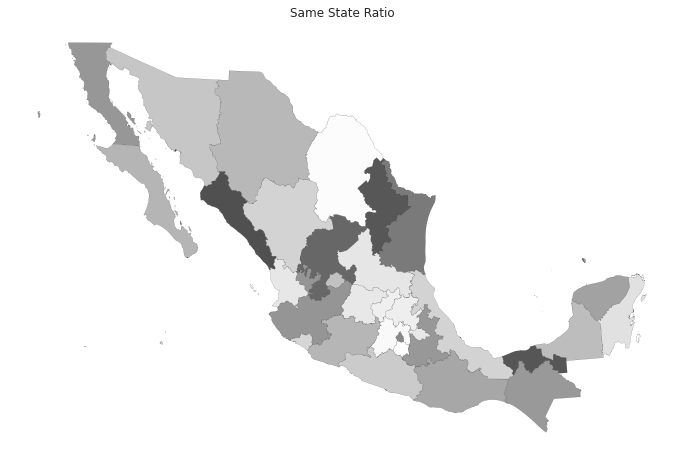

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot('same_state_ratio',
         vmax=0.8,
         cmap='Greys',
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         k=10,
         ax=ax)
ax.set_title("Same State Ratio")
ax.set_axis_off()

In [86]:
# Supplier in their own state
gb_same = cnts.groupby('buyer_state').buyer_variation_within.median().reset_index()
gb_same.columns = ['nomgeo', 'buyer_variation_within']
gb_same = pd.merge(gb_same, gb_buyer, how='left')

gdf = pd.merge(gdf, gb_same[['nomgeo', 'buyer_variation_within']], how='left')

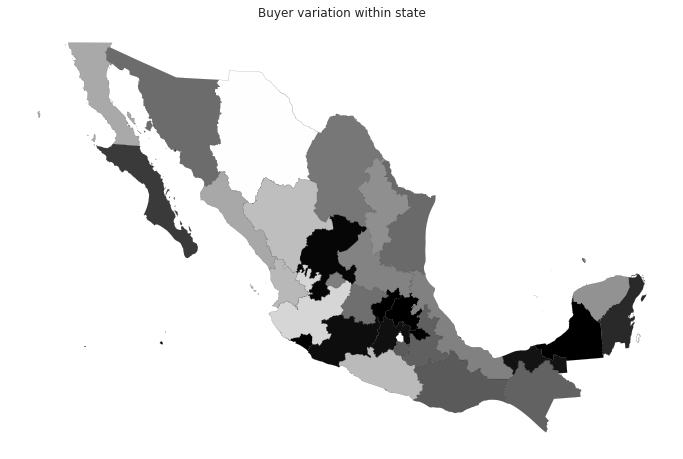

In [94]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot('buyer_variation_within',
         cmap='Greys',
         vmin=0.001,
         vmax=0.004,
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         k=10,
         ax=ax)
ax.set_title("Buyer variation within state")
ax.set_axis_off()

In [96]:
# Supplier in their own state
gb_same = gb_cnts[['state', 'very_high_r']]
gb_same.columns = ['nomgeo', 'very_high_r']
gb_same = pd.merge(gb_same, gb_buyer, how='left')

gdf = pd.merge(gdf, gb_same[['nomgeo', 'very_high_r']], how='left')

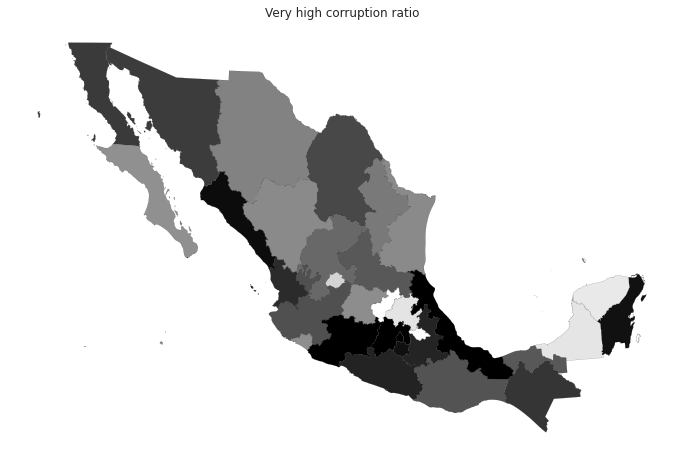

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot('very_high_r',
         cmap='Greys',
         vmax=57.76,
         alpha=1,
         edgecolor='black',
         linewidth=0.1,
         k=10,
         ax=ax)
ax.set_title("Very high corruption ratio")
ax.set_axis_off()